https://watermark.silverchair.com/tacl_a_00008.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqkwggKlBgkqhkiG9w0BBwagggKWMIICkgIBADCCAosGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMdPHYXwG3pcrWAWblAgEQgIICXLAPHfS6DARCCcJOQgNOoHW0d6UCjs3oxS-PWDFPOk7X9faJxJOnQ5Uw6pVYoyKusEjj9WPNYLS9lXu3It3oT9_evEDplawruHZ6wGGCRQaE2lL6UnFonGuX2VA_B78COLDzUNsLq7H8HJxYcnM69qXSXtecSG0BgIxzl5GDuJjEnmw7s0l-fCwtKeu31OCom2mdkQZVvow05n1a1POX4yb_IHr0BfUu2_jpJJdhXp7CT8PuH0NFUwgf9R6nEnQxV0iMnb-31-MrLir4VL1KpJGYvTWhGRYGWgW76E5iSGpIShl47bzyPQcmzwrtv1H5JtOCQ38Xom6pQLb8gX5xlPTnEHxykR2yV_eDu9WlUkty_AHo-CIipkLzW18YDmVAopNNJtBDM6PwA0AzEdhzTk3hM2L2rsevblwlZMyGvpuvxnentatFdU5P8NI7beqdveY8ff0TID8C1lB5u3ZmeYPmcAytAdVt9yyD3iMCRO8CUntiIxJaX6QO0QzI9KPlW3-3RM4WqRq-ZCA3sb9jsLuaftRhEebIGEh_O5zH_H4r6K--NZWNXsEtrbTKWhgTuTTCaUfRIab88OV0MvyBj6S59SwcjSfJnJjOLVXG0d8LqRNuld2eDe-mBUm1PoeLEFrrCfNArKe-GyXejS68fN4bxzKF3vcJWnG054eJG95zvDY0xQeyvPGp0EVqh26f7sQ3O21AHBnqKTL9IvIhHZk3Ytvl9R_-_q26JdmVX-Qve7vU1T5XEHofsvq48CUgG4kNo8CX4cuuM64tEGOCtB6p41tvLhT_TQdFKso

In [1]:
!pwd

/home/dritsakon/repos/paper_greekparliament/src


### Train 

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime
import re
import os
tqdm.pandas()
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
from tabulate import tabulate
import itertools


In [3]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]

(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [4]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [5]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [6]:
#New column year
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove dates after 2019 to catch the three last decades
df = df[df.decade != 2000]# remove dates after 2019 to catch the three last decades

print(set(df.decade.to_list()))

{2010, 1990}


In [7]:
# df.speech = df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
# print('Group by decades...')
# print(datetime.datetime.now())
# PERdecade_df = df.groupby(df.decade)['speech'].progress_apply(sum).reset_index()
# print(datetime.datetime.now())

print(datetime.datetime.now())

print('Group by decades...')
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply('. '.join).reset_index() # add missing dot from end of sentence
print('Tokenize...')
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [token for token in x if token!='' and token!=' '])

print(datetime.datetime.now())

100%|██████████| 2/2 [00:01<00:00,  2.61it/s]

2021-04-17 02:07:53.606337
Group by decades...


  0%|          | 0/2 [00:00<?, ?it/s]

Tokenize...


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

2021-04-17 02:08:37.937896


In [8]:
# PERdecade_df.speech[0] = PERdecade_df.speech[0][:10000]
# PERdecade_df.speech[1] = PERdecade_df.speech[1][:10000]
# print(len(PERdecade_df.speech.iloc[0]))
# print(len(PERdecade_df.speech.iloc[1]))

In [9]:
models_dir =  '../out_files/wordmodels/goldberg_decade_2/'

https://stackoverflow.com/questions/34831551/ensure-the-gensim-generate-the-same-word2vec-model-for-different-runs-on-the-sam
https://stackoverflow.com/questions/54865930/how-to-set-pythonhashseed-for-jupyter-notebook

In [10]:
import random

def train_word2vec(PERdecade_df, iteration, my_seed):
    
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    print('Start training')
    print(datetime.datetime.now())

    for decade, texts in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
        model = Word2Vec(sentences=texts, size=300, window=4, min_count=20, workers=1, seed=my_seed)
        model.save(models_dir+str(decade) + '_' + str(iteration) + ".mdl")

    print(datetime.datetime.now()) 

    
for i in range(2): 
    
    if i==0:
        print('Training first model')
        %env PYTHONHASHSEED=999
        np.random.seed(999)
        random.seed(999)
        train_word2vec(PERdecade_df, i, 999)  
    else:
        print('Training second model')
        %env PYTHONHASHSEED=3
        np.random.seed(3)
        random.seed(3)
        train_word2vec(PERdecade_df, i, 3)    


0it [00:00, ?it/s]

Training first model
env: PYTHONHASHSEED=999
Start training
2021-04-17 02:08:38.054983


2it [19:26, 583.32s/it]
0it [00:00, ?it/s]

2021-04-17 02:28:04.688358
Training second model
env: PYTHONHASHSEED=3
Start training
2021-04-17 02:28:04.742178


2it [21:23, 641.58s/it]

2021-04-17 02:49:27.898399


### Collect words for semantic shift analysis that fulfill the thresholds

Count frequency of words for each decade

In [11]:
df_freq_1990 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade1990.csv')
df_freq_2010 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade2010.csv')

In [12]:
# most frequent words at the top
df_freq_1990 = df_freq_1990.sort_values('frequency', ascending=False)
df_freq_2010 = df_freq_2010.sort_values('frequency', ascending=False)

# collect 200 most frequent words
most_freq_1990 = df_freq_1990.word.head(200).to_list()
most_freq_2010 = df_freq_2010.word.head(200).to_list()

# collect words with less than 200 frequency
least_frequent_1990 = df_freq_1990.loc[df_freq_1990.frequency<200].word.to_list()
least_frequent_2010 = df_freq_2010.loc[df_freq_2010.frequency<200].word.to_list()

In [13]:
# Collect the intersection of the vocabularies that fulfill the frequency thresholds

def collect_words(iteration, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010):

    m1_vocab = [key for key, value in m1.wv.vocab.items() if key!=' ']
    m2_vocab = [key for key, value in m2.wv.vocab.items() if key!=' ']

#     print('1')
    # remove stopwords
    m1_vocab.remove('@sw')                   
    m2_vocab.remove('@sw')
#     print('2')

    # Clean words to search for usage change
    m1_vocab_final = [w for w in m1_vocab if w not in most_freq_1990 and w not in least_frequent_1990]
    m2_vocab_final = [w for w in m2_vocab if w not in most_freq_2010 and w not in least_frequent_2010]
#     print('3')

    final_list = set(m1_vocab_final).intersection(set(m2_vocab_final))
    print(len(final_list))
    
    return m1_vocab, m2_vocab, final_list


### Collect eligible neighbors that fulfill the thresholds

In [14]:
# Define the plausible neighbors to keep as neighbors to final_list words
# They must be in both vocabs and appear more than 100 times in each corpus

over100_1990_list = df_freq_1990.loc[(df_freq_1990.frequency>100), 'word'].to_list()
# print(len(over100_1990_list))
over100_2010_list = df_freq_2010.loc[(df_freq_2010.frequency>100), 'word'].to_list()
over100_intersection = set(over100_1990_list).intersection(set(over100_2010_list))

def collect_neighbors(m1_vocab, m2_vocab):
    intersection_vocabs = list(set(m1_vocab).intersection(set(m2_vocab)))
    intersection_vocabs.remove('')
    print("Vocabulary intersection: ", len(intersection_vocabs))

    plausible_neighbors = [w for w in intersection_vocabs if w in over100_intersection]
    return plausible_neighbors
    


### Compute semantic shift 

In [15]:
import time 

shifts_PERdecade_list=[]
error_list = []

print(datetime.datetime.now())

topn_neighbors = 1000

for i in range(2):
    print('Iteration ', str(i))
    
    m1 = Word2Vec.load(models_dir+'1990_'+str(i)+'.mdl')
    m2 = Word2Vec.load(models_dir+'2010_'+str(i)+'.mdl')
    
    m1_vocab, m2_vocab, final_list = collect_words(i, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010)
    plausible_neighbors = collect_neighbors(m1_vocab, m2_vocab)
    

    for word in tqdm(final_list):
    #     print(word)

        #union of neighbors in two points in time
        neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[word], topn=5000) if w in plausible_neighbors]
    #     print(len(neighbors_t1))
        neighbors_t1 = neighbors_t1[:topn_neighbors]
        neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[word], topn=5000) if w in plausible_neighbors]
    #     print(len(neighbors_t2))
        neighbors_t2 = neighbors_t2[:topn_neighbors]

        if len(neighbors_t1)<topn_neighbors or len(neighbors_t2)<topn_neighbors:
            error_list.append([word, len(neighbors_t1), len(neighbors_t2)])

        score = -len(set(neighbors_t1).intersection(set(neighbors_t2)))
    #     print(score)
        shifts_PERdecade_list.append([word, i, '1990-2010', score, neighbors_t1, neighbors_t2])
    #     break

print(datetime.datetime.now())


2021-04-17 02:49:29.478997
Iteration  0


  0%|          | 0/10446 [00:00<?, ?it/s]

10446
Vocabulary intersection:  41582


100%|██████████| 10446/10446 [9:17:31<00:00,  3.20s/it]


Iteration  1


  0%|          | 0/10446 [00:00<?, ?it/s]

10446
Vocabulary intersection:  41582


100%|██████████| 10446/10446 [11:30:53<00:00,  3.97s/it]

2021-04-17 23:51:27.514795


In [16]:
shifts_PERdecade_df = pd.DataFrame(shifts_PERdecade_list, columns = ['word', 'iteration', 'decade',
                                                                 'score', 'neighbors_t1',
                                                                    'neighbors_t2'])
print(shifts_PERdecade_df.head())

          word  iteration     decade  score  \
0                       0  1990-2010   -750   
1    προεδρικα          0  1990-2010   -551   
2  επισημαινει          0  1990-2010   -598   
3  διαφαινεται          0  1990-2010   -577   
4      εμμεσων          0  1990-2010   -650   

                                        neighbors_t1  \
0  [κυριε, συγχωρειτε, διακοψετε, αγαπητε, προσεξ...   
1  [διαταγματα, εκδοθουν, προεδρικων, υπουργικες,...   
2  [τονιζει, επεσημανε, σημειωνει, περιγραφει, υπ...   
3  [δειχνει, σηματοδοτει, εμφανης, επιβεβαιωνεται...   
4  [αμεσων, φορων, εμμεσους, αμεσους, εμμεσης, επ...   

                                        neighbors_t2  
0  [διεκοψα, διακοψω, διακοπτω, διακοψατε, συγχωρ...  
1  [διαταγματα, προεδρικων, εκδοθουν, διαταγματων...  
2  [τονιζει, επισημαινεται, υπογραμμιζει, διαπιστ...  
3  [αποτυπωνεται, προωθειται, φαινεται, σηματοδοτ...  
4  [αμεσων, φορων, εμμεσους, αυξησεων, επιβαρυνσε...  


In [17]:
print(len(error_list))

2442


In [18]:
set(shifts_PERdecade_df.iteration.to_list())
jjj = shifts_PERdecade_df.word[1]
print(jjj)
print(shifts_PERdecade_df.loc[(shifts_PERdecade_df.word==jjj)])

προεδρικα
            word  iteration     decade  score  \
1      προεδρικα          0  1990-2010   -551   
10447  προεδρικα          1  1990-2010   -541   

                                            neighbors_t1  \
1      [διαταγματα, εκδοθουν, προεδρικων, υπουργικες,...   
10447  [διαταγματα, εκδοθουν, διαταγματων, υπουργικες...   

                                            neighbors_t2  
1      [διαταγματα, προεδρικων, εκδοθουν, διαταγματων...  
10447  [διαταγματα, εκδοθουν, εγκυκλιους, υπουργικες,...  


In [19]:
print(shifts_PERdecade_df.describe())

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('score')

print('Words with the lowest score/ lowest change')
print(shifts_PERdecade_df.head(20))

print('Words with the highest score / highest change')
print(shifts_PERdecade_df.tail(20))

shifts_PERdecade_df.to_csv('../out_files/stability_goldberg_2_iterations_dif_seeds_1_worker_2.csv', index=False)

          iteration         score
count  20892.000000  20892.000000
mean       0.500000   -620.370237
std        0.500012     92.540832
min        0.000000   -820.000000
25%        0.000000   -682.000000
50%        0.500000   -637.000000
75%        1.000000   -581.000000
max        1.000000    -22.000000
Words with the lowest score/ lowest change
                 word  iteration     decade  score  \
16286   ενδιαφερονται          1  1990-2010   -820   
16424     επαναλαβετε          1  1990-2010   -819   
13846      απαντησετε          1  1990-2010   -818   
6818        αρνουνται          0  1990-2010   -816   
2731         δηλωνουν          0  1990-2010   -816   
1844         ανθρωποι          0  1990-2010   -815   
19257  ενδιαφερομενοι          1  1990-2010   -814   
3429    περιορισμενες          0  1990-2010   -812   
11976       εξηγησετε          1  1990-2010   -812   
9122        απαντηστε          0  1990-2010   -811   
17096         κληθουν          1  1990-2010   -810   
340

In [20]:
# for iteration in range(3):
#     subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#     print(iteration)
#     print(subdf.head(10))
#     print(subdf.describe())
#     print('------------------------------------')

In [21]:
# decade_pairs = list(set(shifts_PERdecade_df.decade_pair.to_list()))
# for pair in sorted(decade_pairs):
#     print(pair)
#     decade_df = shifts_PERdecade_df.loc[(shifts_PERdecade_df.decade_pair==pair)].sort_values(by='semantic_similarity').reset_index(drop=True)
#     print(decade_df.describe())
#     print(decade_df.head(20))
# #     decade_df.head(20).to_csv('../../out_files/'+pair+'.csv')

In [22]:
# freq_df = pd.read_csv('../../out_files/freqs_for_semantic_shift_cleaned_data.csv')
# freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)

# print(freq_df.shape)
# # print(freq_df.frequency.to_list())

# pd.set_option('float_format', '{:f}'.format)

# freq_df.describe(percentiles = [0.2, 0.4, 0.6, 0.8])

# freq_subdf = freq_df.loc[(freq_df.frequency>200)] # at least 200 times
# print(freq_subdf.shape)
# freq_subdf = freq_subdf[200:]
# print(print(freq_subdf.shape))

# print(freq_subdf.shape)
# freq_subdf = freq_subdf.reset_index(drop=True)
# print(freq_subdf.tail(2))

In [23]:
# shifts_frequent_words = shifts_PERdecade_df.loc[(shifts_PERdecade_df.word.isin(freq_subdf.word.to_list()))].reset_index(drop=True)

# # add columns frequency and percentage in shifts_frequent_words based on the value of column word
# shifts_frequent_words = pd.merge(shifts_frequent_words, freq_subdf, on=['word'], how='left')   

# print(shifts_frequent_words.head(10))

# print(shifts_frequent_words.tail(2))

# shifts_frequent_words.describe()


[10, 20, 50, 100, 200, 500, 1000] [0.5, 0.65, 0.64, 0.76, 0.74, 0.77, 0.815]


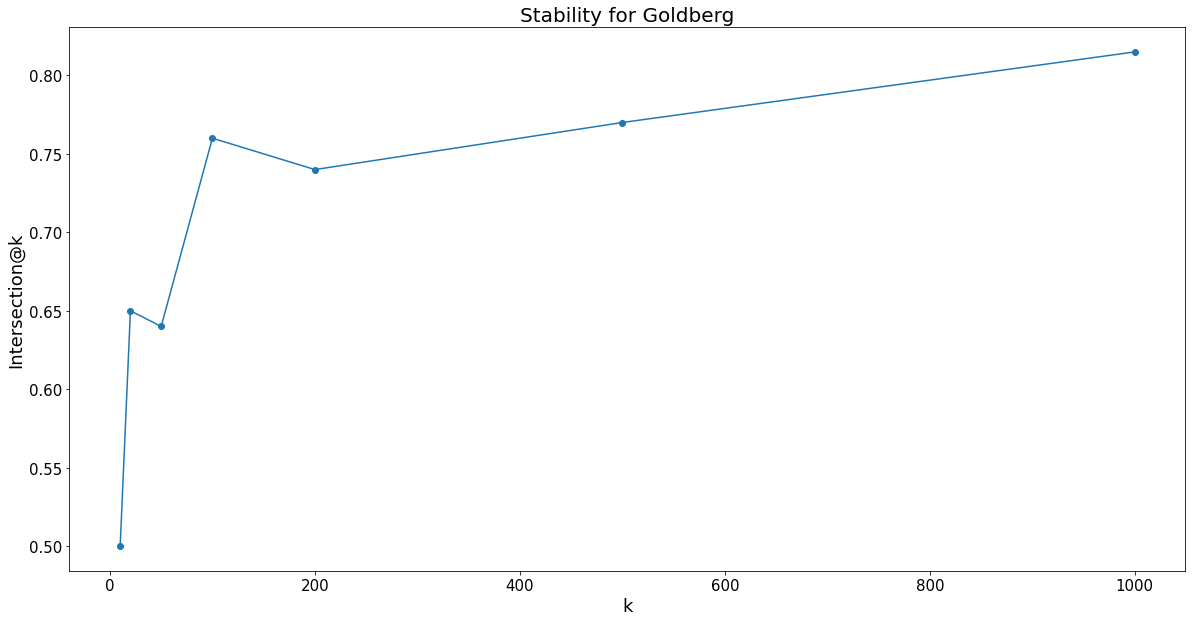

In [24]:
import matplotlib.pyplot as plt

topn_dict = {}
X = []
Y = []

k=[10,20,50,100,200,500,1000]

for n in k:
    
    for iteration in range(2):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#         print(subdf.shape)
    #     print(subdf.columns)
        subdf.sort_values('score', ascending=False).reset_index(drop=True)
    #     print(subdf.head(2))
        topn_dict[iteration] = subdf.head(n).word.to_list()

    intersection = len(set(topn_dict[0]).intersection(set(topn_dict[1])))
    
    Y.append(intersection/n)
    X.append(n)
    
print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)

plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Goldberg', fontsize=20)

plt.savefig('../out_files/stability_goldberg_2.png', dpi=200,  bbox_inches='tight')
